In [2]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import sbcustom as sbc

# statistics
import statsmodels.api as sm

In [3]:
#| echo: false
from IPython.display import display
pd.options.display.notebook_repr_html = False

In [4]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

# Introduction

![](images/model.png){width=500}

> The goal of a model is to provide a simple low-dimensional summary of a dataset. Ideally, the model will capture true “signals” (i.e. patterns generated by the phenomenon of interest), and ignore “noise” (i.e. random variation that you’re not interested in).  
> * physics: models for the physical world

이상적으로, 모형(model)이 현상으로부터 노이즈가 제거된 진정한 신호를 잡아내 주기를 기대.

In [5]:
#| layout-ncol: 2
#| echo: false
diamonds = sm.datasets.get_rdataset("diamonds", "ggplot2").data
diamonds2 = diamonds.query("carat < 2.5").assign(
    lprice=lambda x: np.log2(x.price), 
    lcarat=lambda x: np.log2(x.carat)
)

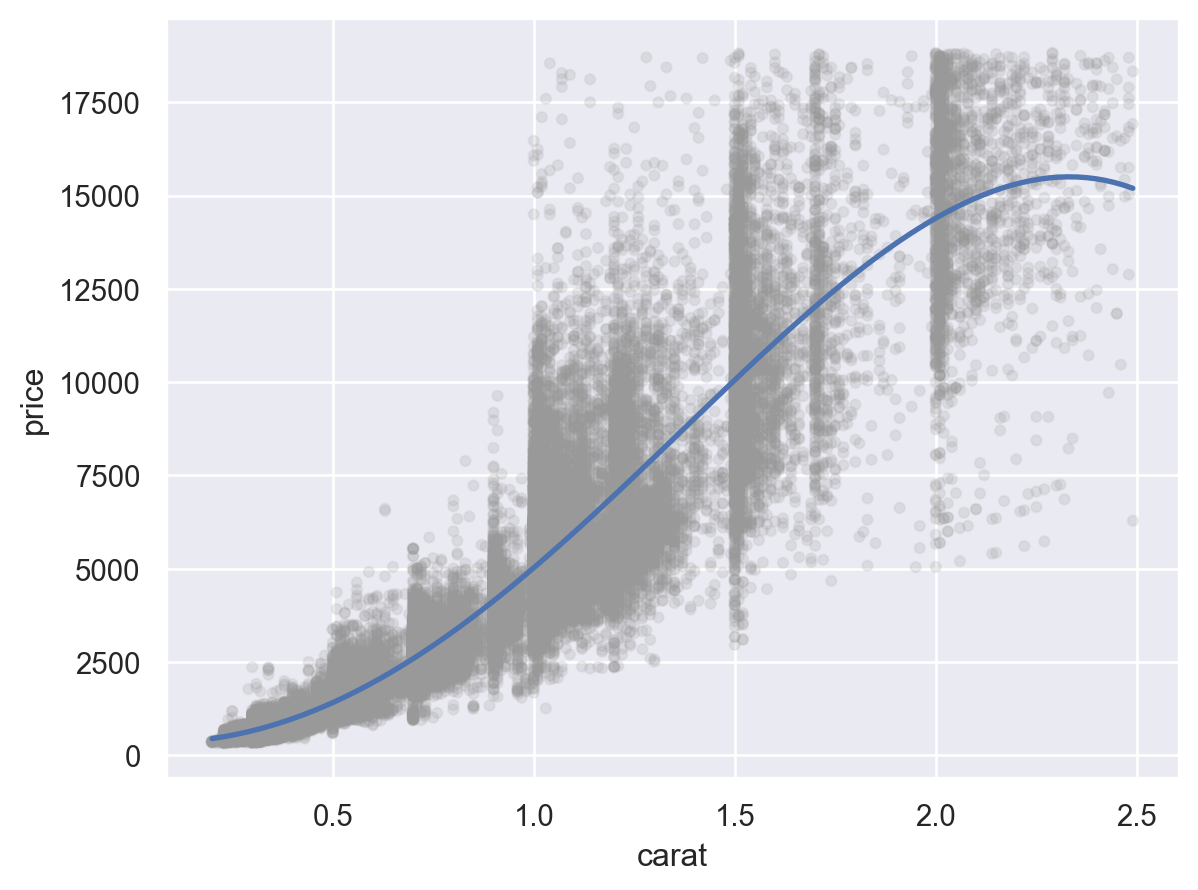

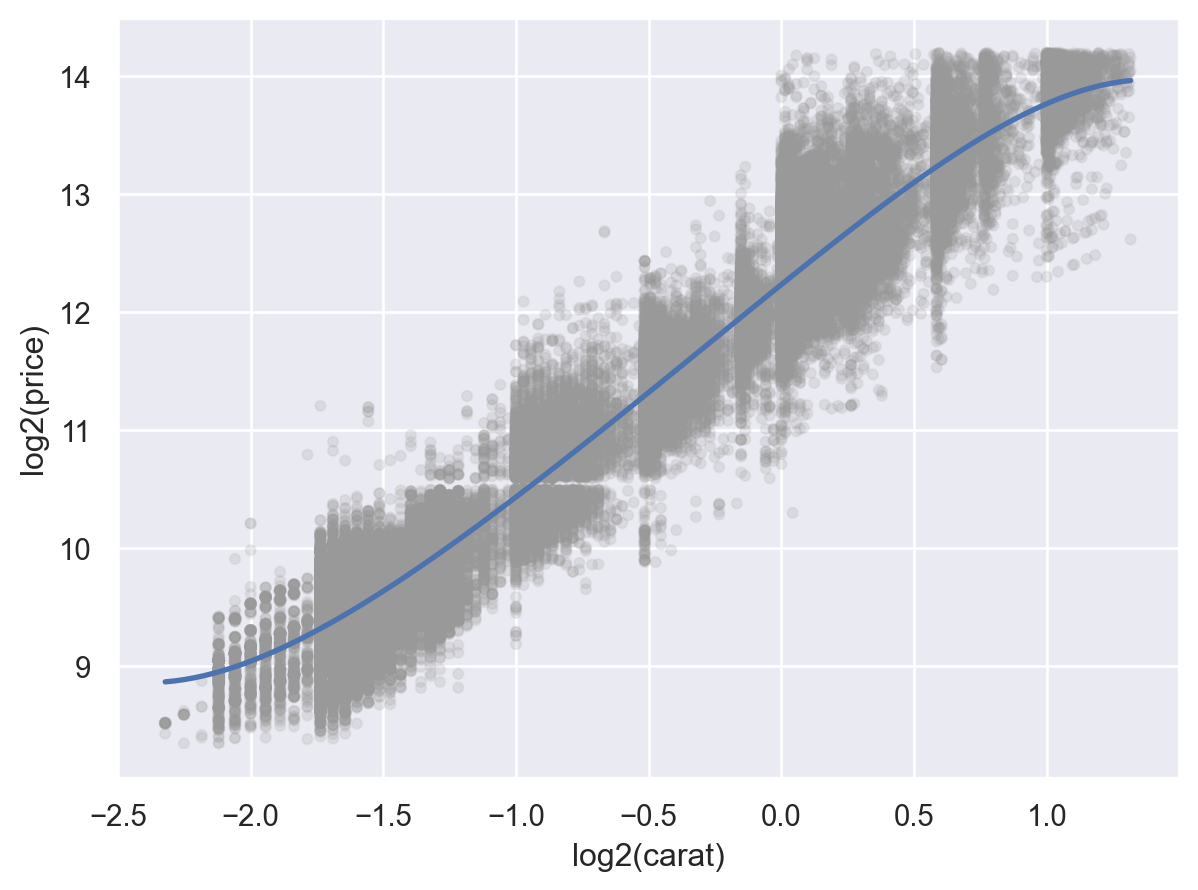

In [12]:
#| layout-ncol: 2
#| echo: false
p1 = (
    so.Plot(diamonds2, x='carat', y='price')
    .add(so.Dots(color=".6", alpha=.1))
    .add(so.Line(linewidth=2), so.PolyFit(5))
    #.label(x="log2(carat)", y="log2(price)")
)

p2 = (
    so.Plot(diamonds2, x='lcarat', y='lprice')
    .add(so.Dots(color=".6", alpha=.1))
    .add(so.Line(linewidth=2), so.PolyFit(5))
    .label(x="log2(carat)", y="log2(price)")
)
display(p1, p2)

예를 들어, 캐럿과 가격의 진정한 관계를 모델로 표현

linear model: y = ax + b

log(price) ~ a * log(carat) + b

나머지 residuals은 노이즈?

이 책에서는 

- **predictive** models(예측 모형)만을 다룸 (supervised learning)
- **data discovery** models은 machine/statistical learning에서... (unsupervised learning)
    - 예측이 아닌, 데이터에 내재하는 흥미로운 관계들을 발견. ex) clustering analysis

## Statistical Learning vs. Machine Learning

Machine learning arose as a subfield of Artificial Intelligence.  
Statistical learning arose as a subfield of Statistics.

There is much overlap — both fields focus on supervised and unsupervised problems:

- Machine learning has a greater emphasis on large scale applications and
    **prediction accuracy.**
- Statistical learning emphasizes models and their **interpretability**, and precision and uncertainty.

But the distinction has become more and more blurred, and there is a great deal of “**cross-fertilization**”.

Machine learning has the upper hand in Marketing!

                Trevor Hastie and Robert Tibshirani, An Introduction to Statistical Learning

## Hypothesis generation vs. hypothesis confirmation

이 책에서 모델은 탐색적 데이터 분석(EDA)의 한 도구로 사용하나
전통적으로 모델은 가설을 검정하거나 모집단에 대한 추론을 위해 사용됨

1. Each observation can either be used for exploration or confirmation, not both.
2. You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.

you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.

통계적 검정에 관심이 있다면, 분석 전에 다음과 같이 데이터를 나누는 것을 고려

 1. 60% of your data goes into a **training** (or exploration) set. You’re allowed to do anything you like with this data: visualise it and fit tons of models to it.
 2. 20% goes into a **query** set. You can use this data to compare models or visualisations by hand, but you’re not allowed to use it as part of an automated process.
 3. 20% is held back for a **test** set. You can only use this data ONCE, to test your final model. (최종 모형의 테스트)

# Model basics

우선, simulated 데이터셋으로 모형을 세우는 방식을 들여다보면서 본질적인 부분을 익히고자 함.

모델은 두 부분으로 나뉘는데

1. **A family of models**를 정의: generic 패턴을 표현해 줄 수 있는 모델 타입
   
   예를 들어,

- 만약, 선형적인 관계라면 선형 모델인 &nbsp; $y = a_2 x + a_1$
- 곡선 관계라면 가령, &nbsp; $y = a_2 x^{a_1}$
  
  $a_1, a_2, a_3$는 패턴을 잡아낼 수 있도록 변하는 파라미터
        
2. **A fitted model**을 생성: 데이터에 가장 가까운(적합한) 파라미터에 해당하는 특정 모델을 선택: "fit a model to data”
    
    예를 들어,

   - $y = 3x+7$
   - $y = 9x^{1.6}$

A fitted model은 a family of models 중에 데이터에 가장 가까운 모델임

- 이는 소위 “**best**” model일 뿐
- “good” model임을 뜻하지 않고, “true” model임을 뜻하는 것은 더더욱 아님

> All models are wrong, but some are useful.  
> The goal of a model is not to uncover truth, but to discover a simple approximation that is still useful.

## A simple model

In [13]:
sim1 = pd.read_csv("data/sim1.csv")

In [143]:
sim1

     x     y
0    1  4.20
1    1  7.51
2    1  2.13
..  ..   ...
27  10 24.97
28  10 23.35
29  10 21.98

[30 rows x 2 columns]

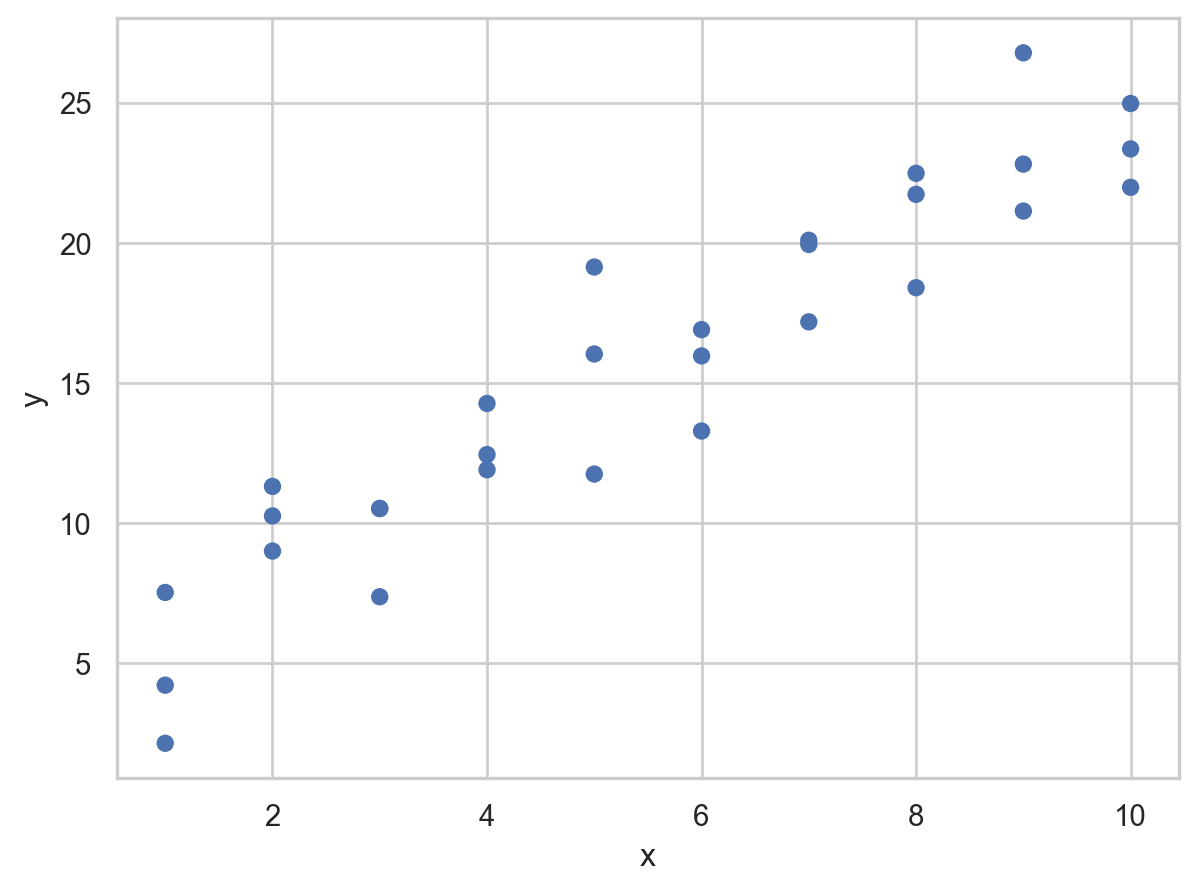

In [215]:
(
    so.Plot(sim1, x='x', y='y')
    .add(so.Dot())
    .theme({**sns.axes_style("whitegrid")})
)

- 패턴: 강한 선형 관계
- 선형 모델 family인  $y = a_2 x + a_1$을 세움
- 무수히 많은 $a_1, a_2$의 값들 중 위 데이터에 가장 가까운 값을 찾음
    - 그 예로, 임의로 250개의 선형 모델을 그려봄

In [158]:
# create a grid for x: (-5, 20), y:(1, 3)
np.random.seed(123)
a1 = np.random.uniform(-20, 40, 250)
a2 = np.random.uniform(-5, 5, 250)

models = pd.DataFrame(dict(a1=a1, a2=a2))

In [159]:
df = sim1[["x"]]

for i in range(250):
    var = f"y{i}"
    df_i = pd.DataFrame({var: models.iat[i, 0] + models.iat[i, 1] * sim1.x})
    df = pd.concat([df, df_i], axis=1)

df_long = df.set_index("x").stack().reset_index(name="y").rename(columns={"level_1": "model"})

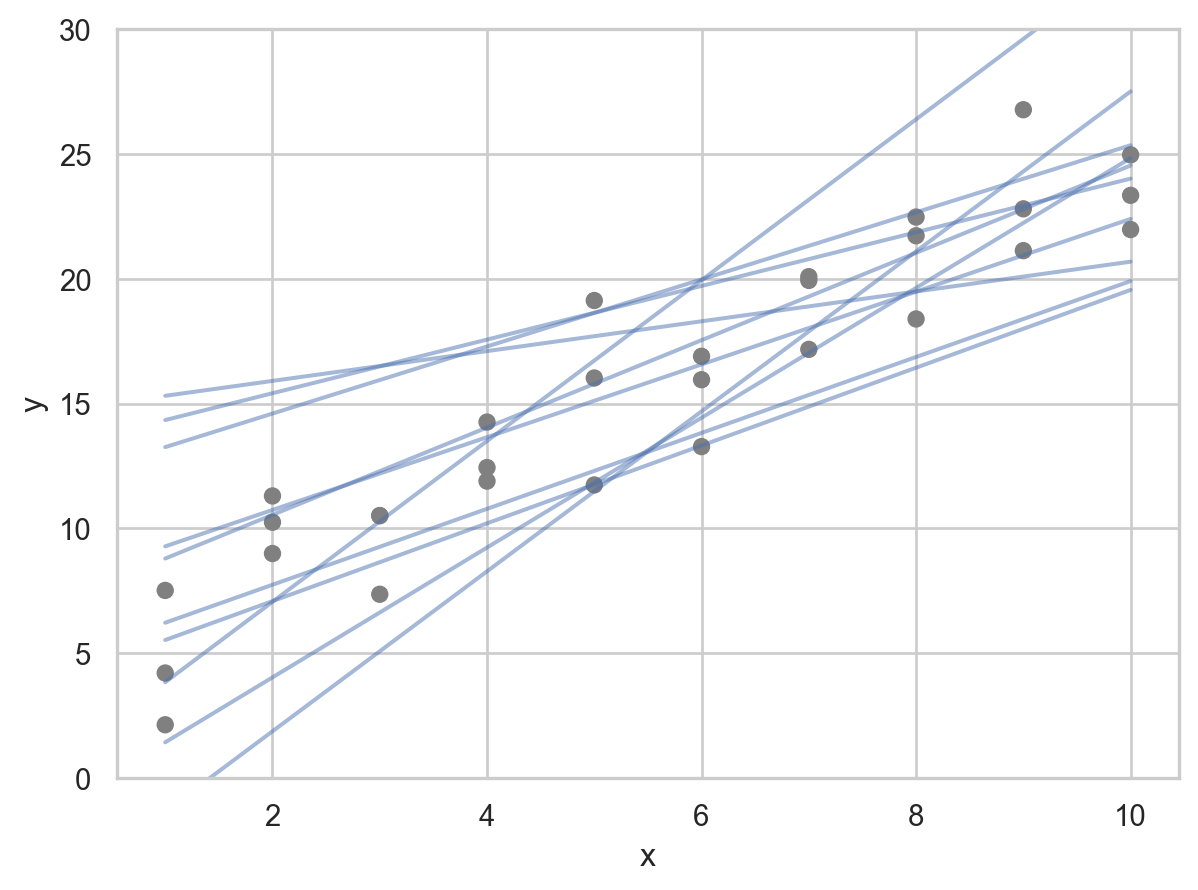

In [214]:
(
    so.Plot(df_long, x='x', y='y', group='model')
    .add(so.Dot(color=".5"), x=sim1.x, y=sim1.y)
    .add(so.Line(linewidth=1.5, alpha=.5))
    .limit(y=(0, 30))
    .theme({**sns.axes_style("whitegrid")})
)

이 선형모델 중 데이터에 가장 “가까운" 모델을 찾고자 하는데, 데이터와 모델과의 거리를 정의해야 함.

$d =|~data - model~|$

예) 모델과 데이터의 수직 거리의 총체 (residuals)

![](images/residual.png){width=700}

Model 1.1: $y = 1.5x+7$의 경우, 이 모델이 예측하는 값들

In [161]:
def model1(a, data):
    return a[0] + a[1] * data.x

model1([7, 1.5], sim1).values

array([ 8.5,  8.5,  8.5, 10. , 10. , 10. , 11.5, 11.5, 11.5, 13. , 13. ,
       13. , 14.5, 14.5, 14.5, 16. , 16. , 16. , 17.5, 17.5, 17.5, 19. ,
       19. , 19. , 20.5, 20.5, 20.5, 22. , 22. , 22. ])

::: {.callout-note}

#### Model evaluation: RMSE, MAE

**The prediction accuracy** of the models 

- Root-mean-squared deviation/error: $RMSE = \displaystyle\sqrt{\frac{1}{n} \sum_{i=1}^{n}{(y_i -\hat y_i)^2}}$  

- Mean absolute error: $MAE = \displaystyle\frac{1}{n} \sum_{i=1}^{n}{|~y_i -\hat y_i~|}$ : 이상치에 덜 민감함

:::

Model 1.1의 RMSE: 

In [163]:
def measure_distance(mod, data):
    diff = data.y - model1(mod, data) # 실제값 - 모델 예측값
    return np.sqrt(np.mean(diff ** 2)) # 오차 제곱합

print(f"{measure_distance([7, 1.5], sim1):.2f}") # RMSE

2.67


즉, 데이터셋 sim1과 model 1.1 과의 거리 $d=|~sim1 -model1~| = 2.67$

위의 250개의 모델에 대해 각각 거리를 구하면

In [164]:
def sim1_dist(a1, a2):
    return measure_distance([a1, a2], sim1)

models = models.assign(
    dist=models.apply(lambda x: sim1_dist(x.a1, x.a2), axis=1)
)
models

       a1    a2  dist
0   21.79 -2.92 17.42
1   -2.83 -0.57 22.83
2   -6.39  2.16 10.26
..    ...   ...   ...
247  0.51  4.19 10.38
248 27.94 -0.84 11.59
249 27.93  2.45 25.99

[250 rows x 3 columns]

이 중 제일 좋은 모델(dist가 최소) 10개의 모델을 그리면,

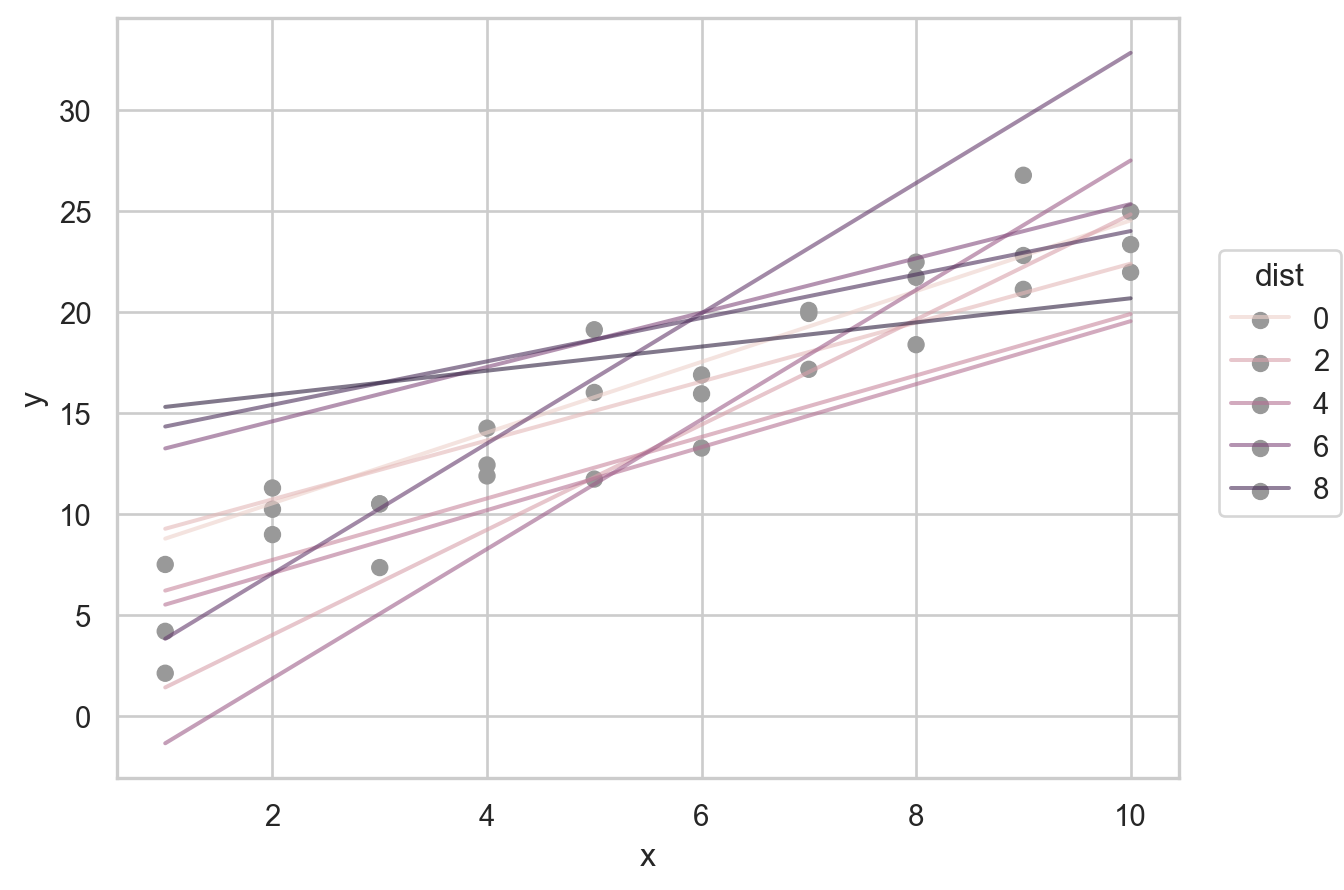

In [216]:
model_top = models.nsmallest(10, "dist").sort_values("dist")

df = sim1[["x"]]

for i in range(10):
    var = f"y{i}"
    df_i = pd.DataFrame({var: model_top.iat[i, 0] + model_top.iat[i, 1] * sim1.x})
    df = pd.concat([df, df_i], axis=1)

df_long = df.set_index("x").stack().reset_index(name="y").rename(columns={"level_1": "model"})

df_long["dist"] = df_long.model.str.split("y", expand=True)[1].astype("int64")

(
    so.Plot(df_long, x='x', y='y', group='model', color="dist")
    .add(so.Dot(color=".6"), x=sim1.x, y=sim1.y)
    .add(so.Line(linewidth=1.5, alpha=.6))
    .theme({**sns.axes_style("whitegrid")})
)

250개의 모델 중 10개의 모델을 다음과 같은 $(a1, a2)$ 평면으로 살펴보면,  
즉, model space라고 볼 수 있음

오렌지 색은 위에서 구한 10 best models

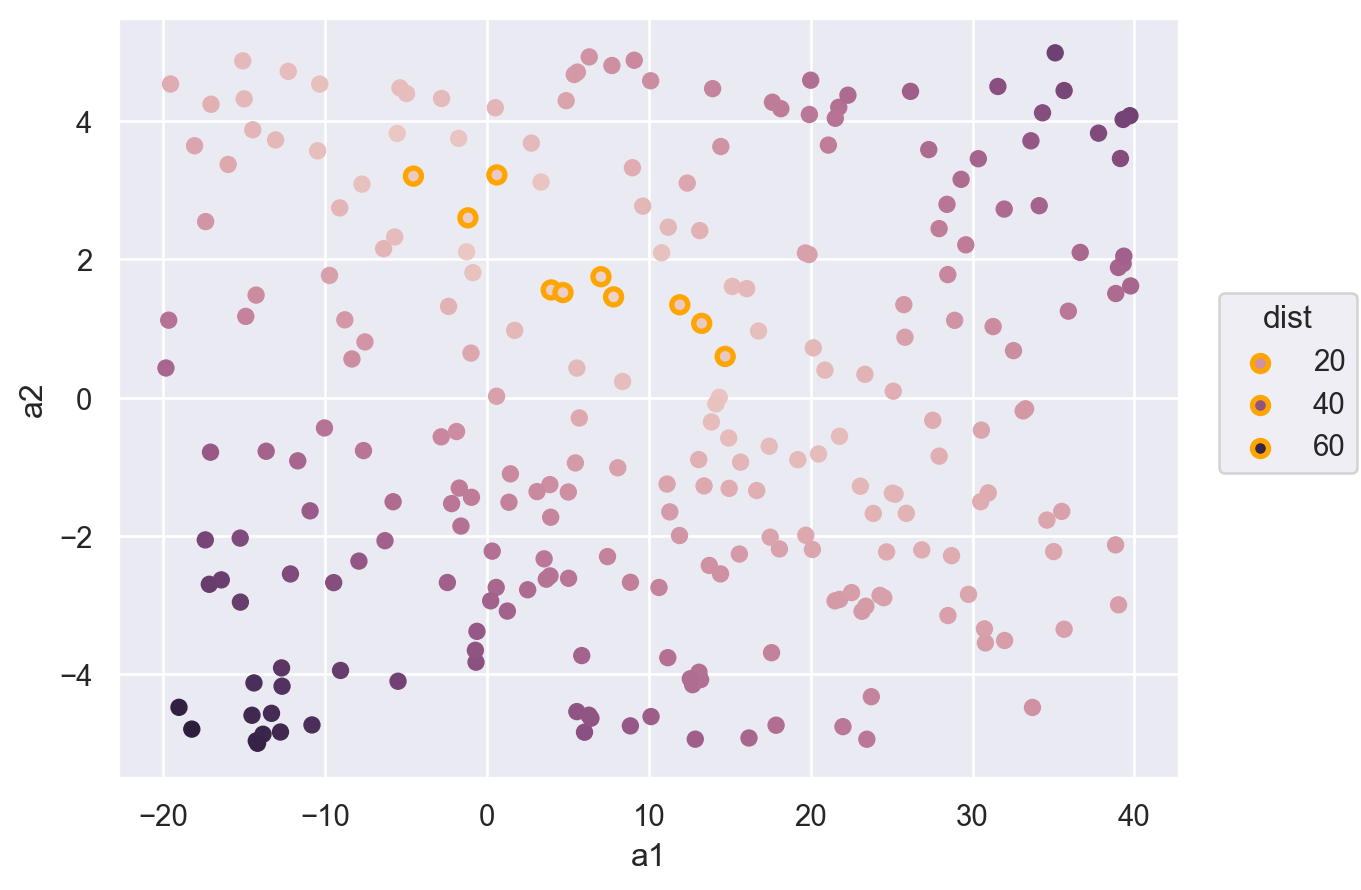

In [210]:
(
    so.Plot(models, x='a1', y='a2', color='dist')
    .add(so.Dot())
    .add(so.Dot(edgecolor="orange", edgewidth=2), x=model_top.a1, y=model_top.a2)
)

점차 촘촘한 간격으로 grid search를 하면서 거리를 최소로 하는 모델을 찾아가는 것이고, 실제로는 Newton-Raphson search를 통해 최소값을 구하는 알고리즘을 통해 구할 수 있음.

즉, 거리를 최소로 하는 a1, a2를 찾으면,

In [230]:
#| echo: true
from scipy.optimize import minimize
minimize(measure_distance, [0, 0], args=(sim1)).x

array([4.22, 2.05])

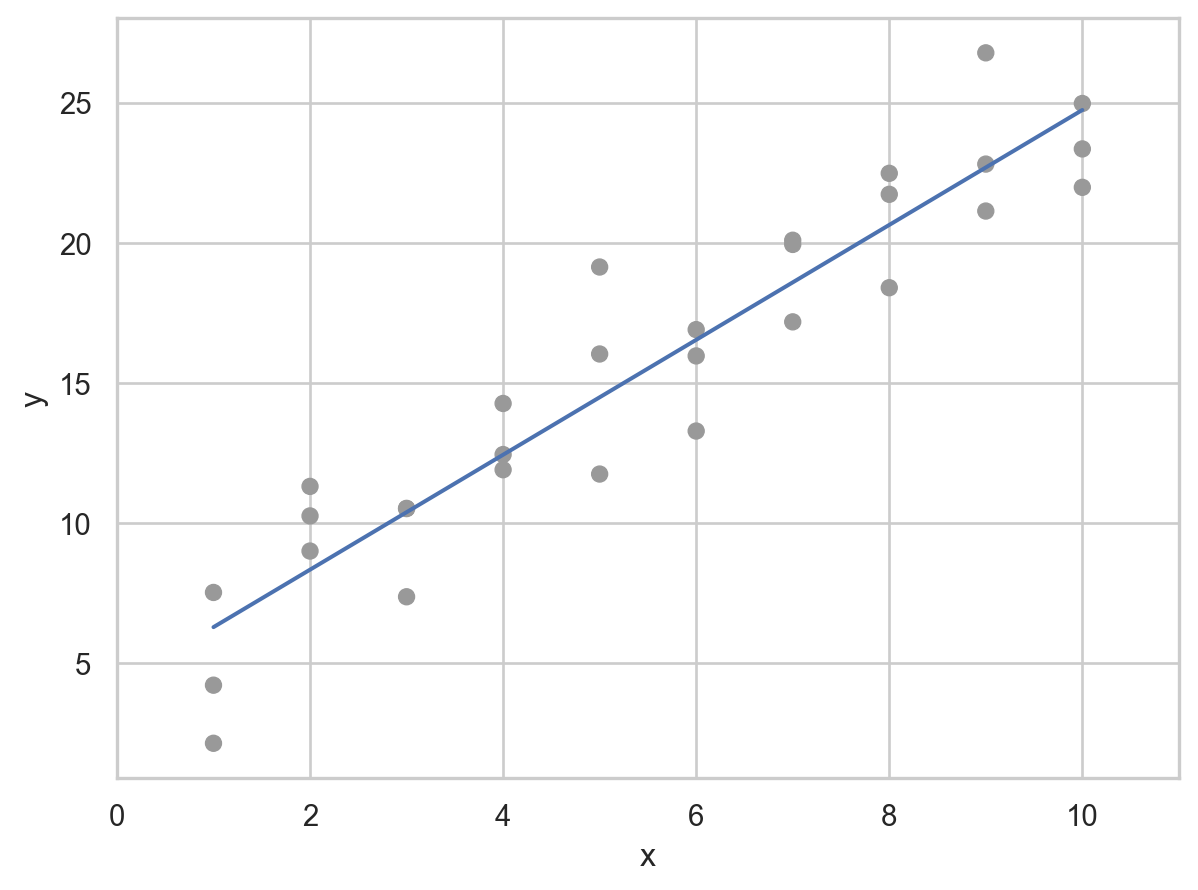

In [234]:
(
    so.Plot(sim1, x='x', y='y')
    .add(so.Dot(color=".6"))
    .add(so.Line(), so.PolyFit(1))
    .limit(x=(0, 11))
    .theme({**sns.axes_style("whitegrid")})
)

## Summary
sim1을 이용한 위의 예는 모든 모델에 적용될 수 있음

- 즉, $y = f(x1, x2,...)$ 형태의 a family of models을 구성한 후
- 모델과 데이터와의 거리 $d =|~data - model~|$를 정의한 후
- 거리 $d$가 최소가 되는 파라미터를 구하면, a family of models 중 **best model**을 만들 수 있음
- 새로운 a family of models을 구성해서 위를 반복하면, 여러 다른 모델들을 비교할 수 있음

In [219]:
from statsmodels.formula.api import ols

sim1_mod = ols("y ~ x", data = sim1)
sim1_mod.fit().params

Intercept   4.22
x           2.05
dtype: float64

앞서 다룬 선형 모형, linear (regression) model은 일반적인 $\hat{y} = a_0 + a_1 x_1 + a_2 x_2 + ~... ~ + a_n x_n$ 형태를 띄고,

- 앞의 예는 $n=1$ 에 해당하며, $\hat{y} =a_0 +a_1x_1$에 대해서 다음과 같이 편리하게 적용할 수있음
        
    ```python
    from statsmodels.formula.api import ols

    sim1_mod <- ols("y ~ x", data = sim1)

    sim1_mod.fit().params # 모델의 parameter 즉, coefficients를 내줌
    # Intercept   4.22
    # x           2.05  # 위에서 구한 파라미터값과 동일함
    ```

    (참고)
    Linear models의 경우 위에서 처럼 optimization을 이용하지 않고 방정식의 해를 구하듯 exact form으로 최소값을 구함

- $n=2$ 인 경우, 즉 두 변수 `x1, x2`로 `y`를 예측하는 경우,
    
    ```python
    ols("y ~ x1 + x2", data = df)
    ```

- 모형 세울 때, **Wilkinson-Rodgers notation**을 사용하는 것이 매우 효과적인데,  
  (initially described in Symbolic Description of Factorial Models for Analysis of Variance by G. N. Wilkinson and C. E. Rogers, 1973)
  - **formula:** `y ~ x1 + x2`는 모형 $\hat{y} = a_0 +a_1x_1 + a_2x_2$ 을 의미
  - `statsmodels`는 formula notation으로 모형을 세우는 것을 지원함: [link](https://www.statsmodels.org/stable/example_formulas.html)
  - `sklearn`은 formula notation을 직접 지원하지 않지만, `patsy` [패키지](https://patsy.readthedocs.io/en/latest/index.html)를 이용하여 design matrix를 직접 얻어 적용할 수 있음: [patsy in scikit-learn](https://learn-scikit.oneoffcoder.com/patsy.html) 또는 [PatsyTransformer](https://scikit-lego.netlify.app/api/preprocessing.html#sklego.preprocessing.PatsyTransformer)
- 예를 들어,

In [5]:
#| echo: true
houses = sm.datasets.get_rdataset("SaratogaHouses", "mosaicData").data

# statsmodels
from statsmodels.formula.api import ols

ols("price ~ livingArea + bedrooms", data=houses).fit().params

Intercept     36667.90
livingArea      125.40
bedrooms     -14196.77
dtype: float64

In [6]:
#| layout-ncol: 2
#| echo: true
#| output: false
# patsy
from patsy import dmatrices # design matrix

formula = "price ~ livingArea + bedrooms"
y, X = dmatrices(formula, data=houses, return_type="dataframe")

print(y); print(X)

      Intercept  livingArea  bedrooms
0          1.00      906.00      2.00
1          1.00     1953.00      3.00
2          1.00     1944.00      4.00
...         ...         ...       ...
1725       1.00     1099.00      2.00
1726       1.00     1225.00      3.00
1727       1.00     1959.00      3.00

[1728 rows x 3 columns]
         price
0    132500.00
1    181115.00
2    109000.00
...        ...
1725 194900.00
1726 125000.00
1727 111300.00

[1728 rows x 1 columns]


In [11]:
#| layout-ncol: 2
display(y, X)

         price
0    132500.00
1    181115.00
2    109000.00
...        ...
1725 194900.00
1726 125000.00
1727 111300.00

[1728 rows x 1 columns]

      livingArea  bedrooms
0         906.00      2.00
1        1953.00      3.00
2        1944.00      4.00
...          ...       ...
1725     1099.00      2.00
1726     1225.00      3.00
1727     1959.00      3.00

[1728 rows x 2 columns]

In [8]:
#| echo: true
# scikit-learn
from sklearn.linear_model import LinearRegression

formula = "price ~ livingArea + bedrooms - 1"
y, X = dmatrices(formula, data=houses, return_type="dataframe")

mod = LinearRegression().fit(X, y)

print(mod.coef_); print(mod.intercept_)

In [10]:
#| layout-ncol: 2
display(mod.coef_, mod.intercept_)

array([[   125.4 , -14196.77]])

array([36667.9])

# Visualising models

Fitted models을 이해하기 위해 모델이 예측하는 부분(prediction)과 모델이 놓친 부분(residuals)을 시각화해서 보는 것이 유용함

## Predictions: the pattern that the model has captured

우선, 예측 변수들의 데이터 값을 커버하는 grid를 구성

In [14]:
#| echo: true
sim1

     x     y
0    1  4.20
1    1  7.51
2    1  2.13
..  ..   ...
27  10 24.97
28  10 23.35
29  10 21.98

[30 rows x 2 columns]

In [25]:
#| echo: true
# create a grid for the range of x sim1
grid = pd.DataFrame(dict(x=np.linspace(sim1.x.min(), sim1.x.max(), 10)))

모델에 grid를 입력하여 prediction값을 추가

In [26]:
#| echo: true
# a model for sim1
sim1_mod = ols("y ~ x", data=sim1).fit()

grid["pred"] = sim1_mod.predict(grid) # column 이름이 매치되어야 함
grid

       x  pred
0   1.00  6.27
1   2.00  8.32
2   3.00 10.38
..   ...   ...
7   8.00 20.63
8   9.00 22.68
9  10.00 24.74

[10 rows x 2 columns]

In [31]:
#| echo: true
# 또는
sim1["fitted"] = sim1_mod.fittedvalues
sim1["fitted2"] = sim1_mod.predict(sim1.x)

sim1


     x     y  fitted  fitted2
0    1  4.20    6.27     6.27
1    1  7.51    6.27     6.27
2    1  2.13    6.27     6.27
..  ..   ...     ...      ...
27  10 24.97   24.74    24.74
28  10 23.35   24.74    24.74
29  10 21.98   24.74    24.74

[30 rows x 4 columns]

prediction을 시각화

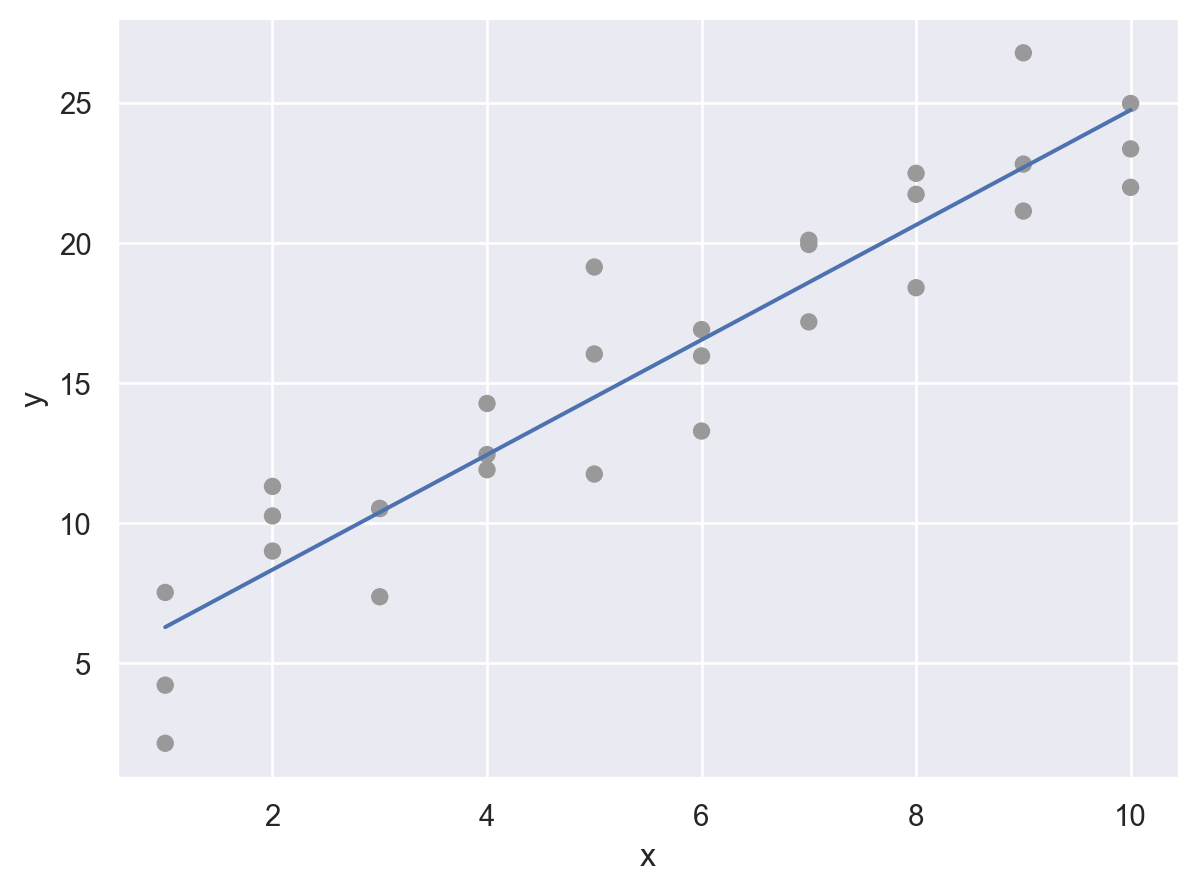

In [28]:
#| echo: true
(
    so.Plot(sim1, x='x', y='y')
    .add(so.Dot(color=".6"))
    .add(so.Line(), x=grid.x, y=grid.pred) # prediction!
)

## Residuals: what the model has missed.
$e = Y - \hat{Y}$ : 관측값 - 예측값

In [32]:
#| echo: true
sim1["resid"] = sim1_mod.resid  # Y - Y_hat

In [33]:
#| echo: true
sim1

     x     y  fitted  fitted2  resid
0    1  4.20    6.27     6.27  -2.07
1    1  7.51    6.27     6.27   1.24
2    1  2.13    6.27     6.27  -4.15
..  ..   ...     ...      ...    ...
27  10 24.97   24.74    24.74   0.23
28  10 23.35   24.74    24.74  -1.39
29  10 21.98   24.74    24.74  -2.76

[30 rows x 5 columns]

우선, residuals의 분포를 시각화해서 살펴보면,

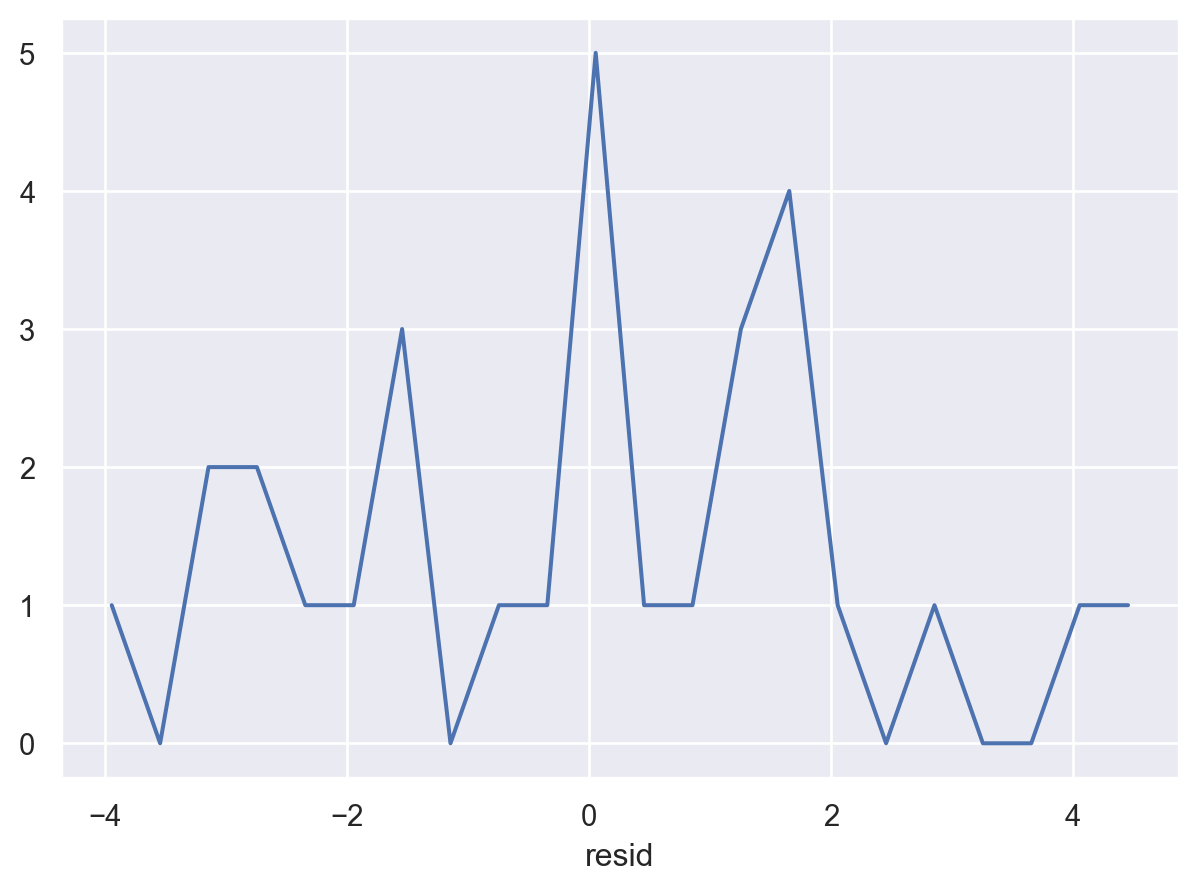

In [41]:
#| echo: true
(
    so.Plot(sim1, x='resid')
    .add(so.Line(), so.Hist(binwidth=.4))
)

예측 변수와 residuals의 관계를 시각화해서 보면,

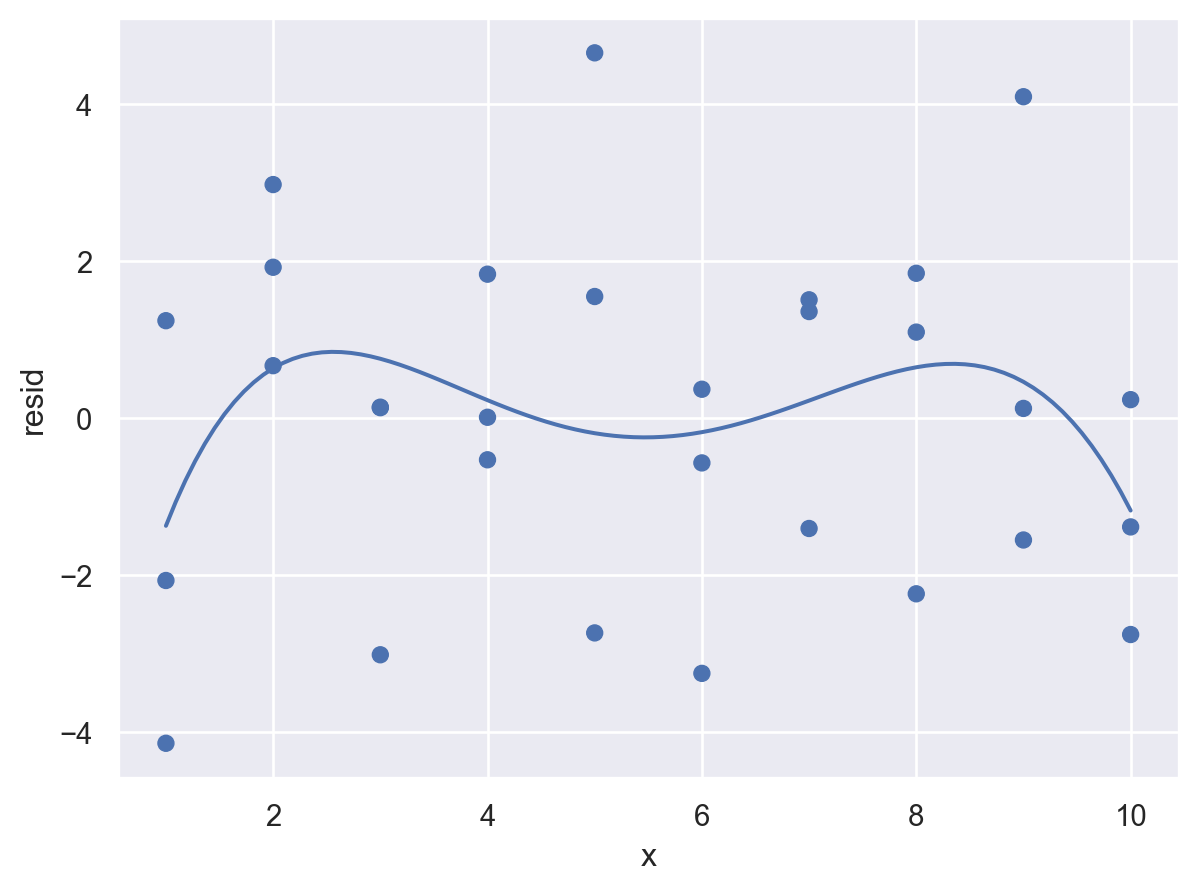

In [43]:
#| echo: true
(
    so.Plot(sim1, x='x', y='resid')
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(5))
)

위의 residuals은 특별한 패턴을 보이지 않아야 모델이 데이터의 패턴을 잘 잡아낸 것으로 판단할 수 있음.  
아래는 원래 데이터와 일차 선형 모형에 대한 예측값의 관계를 시각화한 것

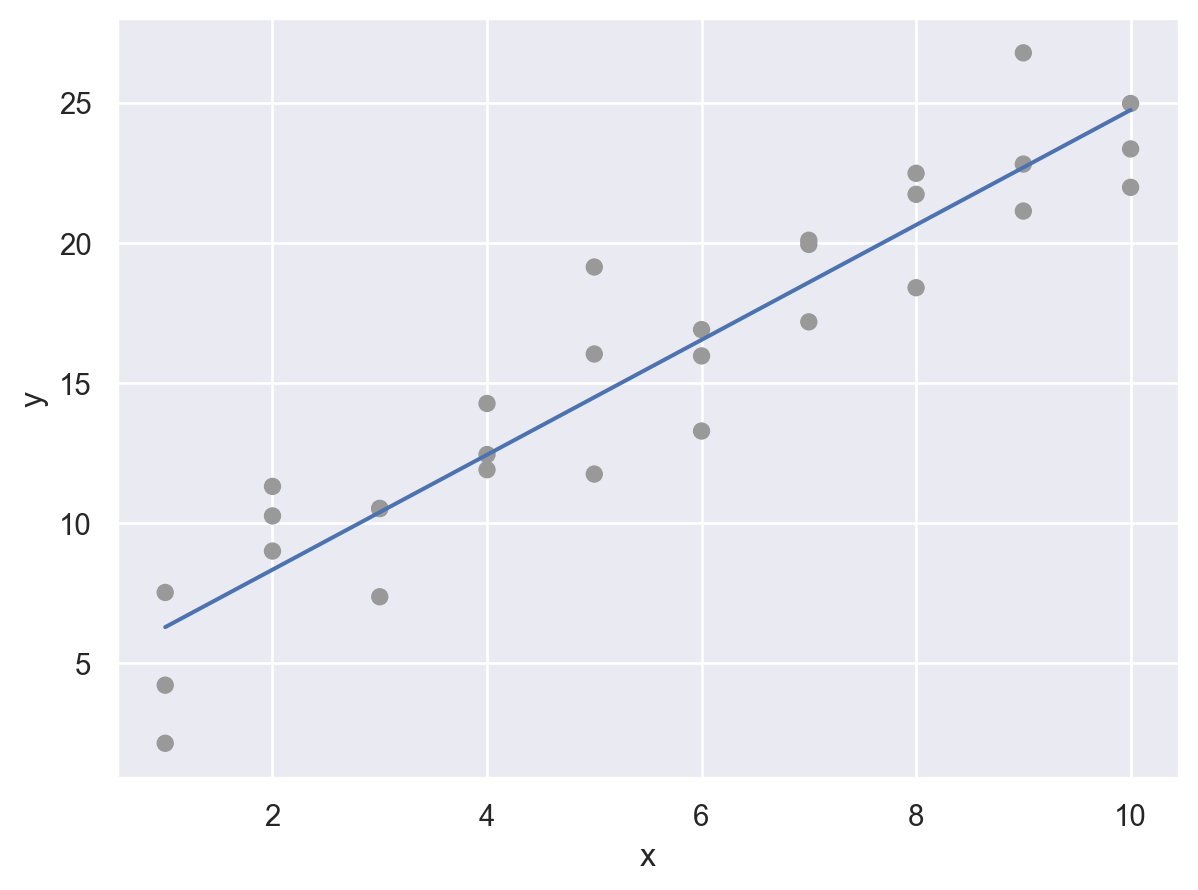

In [45]:
(
    so.Plot(sim1, x='x', y='y')
    .add(so.Dot(color=".6"))
    .add(so.Line(), so.PolyFit(1))
)

Residuals에 패턴이 보이는 경우

In [47]:
y = sim1.y
x = sim1.x
yy = y + 0.2 * (x - 2.5) * (x - 7.5)
sim1["y2"] = yy

mod2 = ols('y2 ~ x', data = sim1).fit()
sim1["resid2"] = mod2.resid

In [56]:
p1 = (
    so.Plot(sim1, x='x', y='y2')
    .add(so.Dot(color=".6"))
)
p2 = (
    so.Plot(sim1, x='x', y='y2')
    .add(so.Dot(color=".6"))
    .add(so.Line(alpha=.5), so.PolyFit(1))
    .add(so.Line(alpha=.5), so.PolyFit(5))
)
p3 = (
    so.Plot(sim1, x='x', y='resid2')
    .add(so.Dot(color=".6"))
    .add(so.Line(alpha=.5), so.PolyFit(5))
)

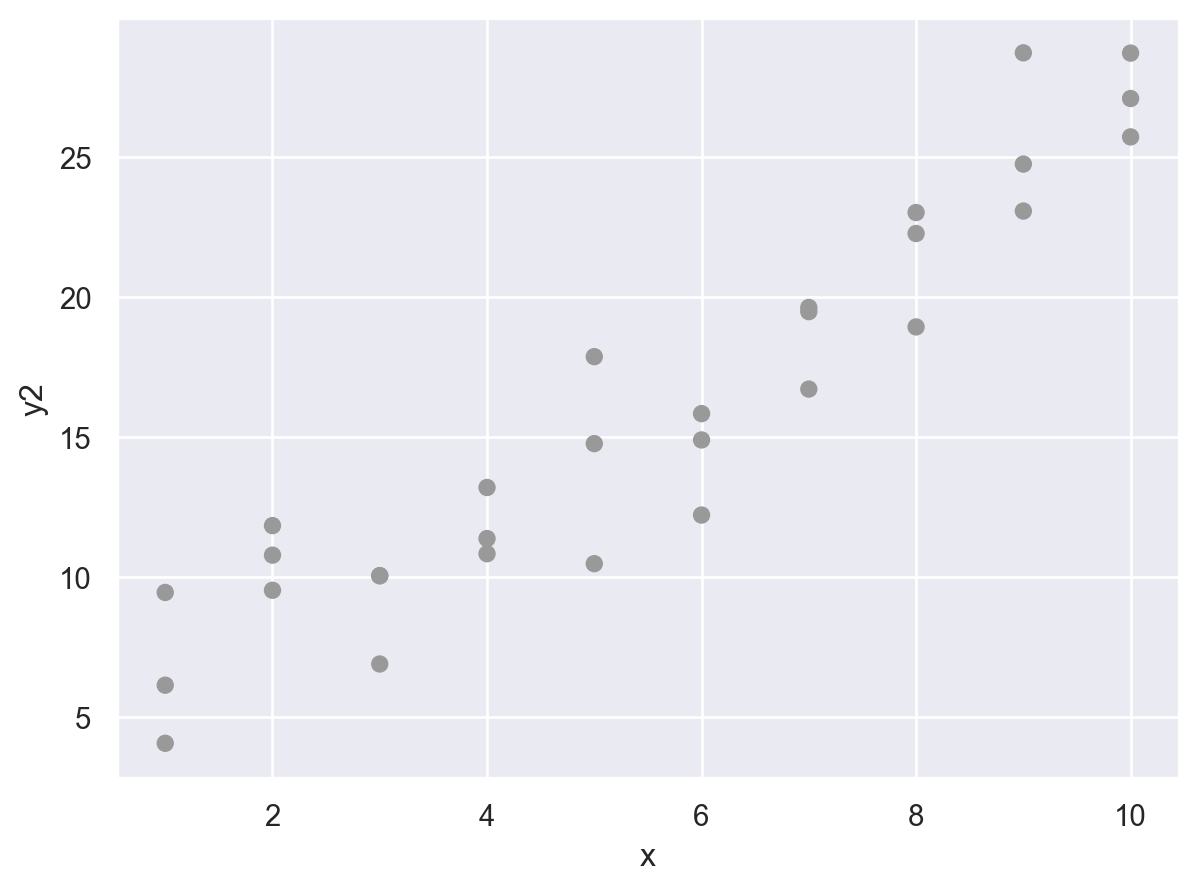

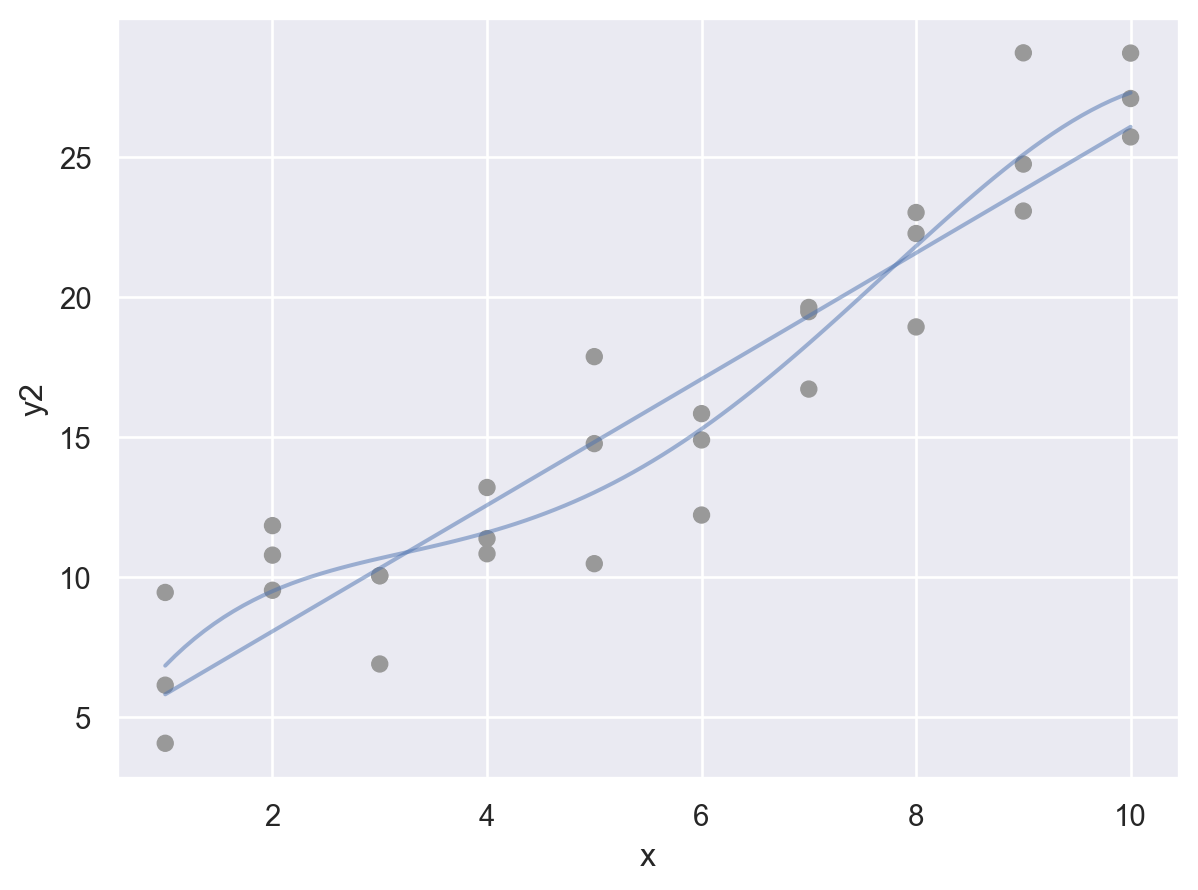

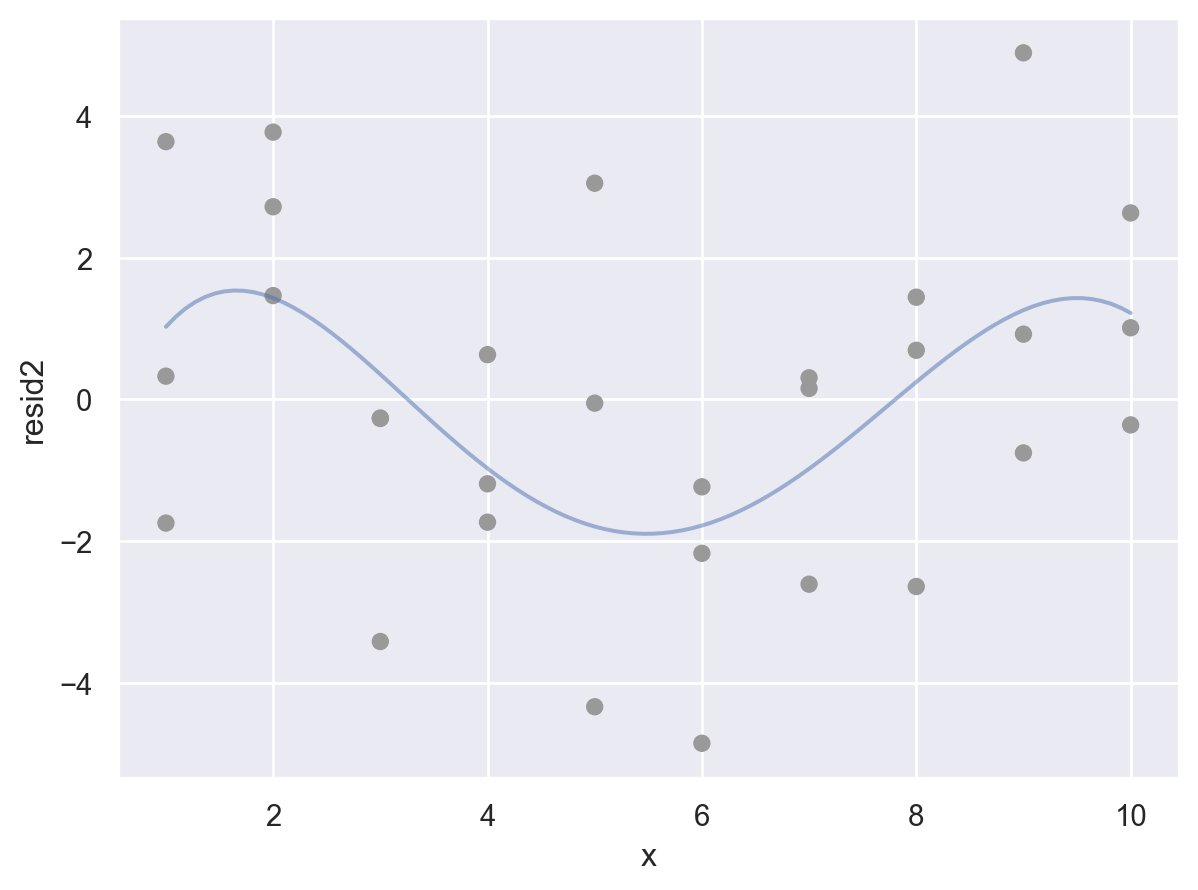

In [57]:
#| layout-ncol: 2
display(p1, p2, p3)

## Categorical variables

카테고리 변수가 predictor인 경우 복잡해짐

- formula `y ~ sex`의 경우, $y=a_0 +a_1sex$ 로 변환될 수 없음 (성별을 연산할 수 없음)
- 실제로, formula는 $sex[T.male]$ 라는 indicator/dummy variable을 새로 만들어 membership을 나타내 줌:  
  **dummy-coding** 또는 **one-hot encoding** 이라고 부름.
  - $y=a_0 +a_1sex[T.male]$ &nbsp; (남성일 때, $sex[T.male]=1$, 그렇지 않은 경우 0)

In [60]:
#| echo: true
df = pd.DataFrame({"sex": ["male", "female", "male"], "response": [10, 21, 13]})
df

      sex  response
0    male        10
1  female        21
2    male        13

In [62]:
#| echo: true
y, X = dmatrices("response ~ sex", data=df, return_type="dataframe")
X

   Intercept  sex[T.male]
0       1.00         1.00
1       1.00         0.00
2       1.00         1.00

<br>

- 세 개의 범주인 경우: 가령, 아래와 같이 3개의 범주를 가졌다면, 두 개의 변수 `sex[T.male]`,  `sex[T.neutral]`가 생성
- 일반적으로 `n`개의 범주를 가진 변수인 경우 `n-1`개의 변수가 생성

In [65]:
#| echo: true
df = pd.DataFrame({"sex": ["male", "female", "male", "neutral"], "response": [10, 21, 13, 5]})
df

       sex  response
0     male        10
1   female        21
2     male        13
3  neutral         5

In [66]:
#| echo: true
y, X = dmatrices("response ~ sex", data=df, return_type="dataframe")
X

   Intercept  sex[T.male]  sex[T.neutral]
0       1.00         1.00            0.00
1       1.00         0.00            0.00
2       1.00         1.00            0.00
3       1.00         0.00            1.00

Formula는 편리하게 범주형 변수를 처리해 주기 때문에 범주형 변수의 복잡한 처리과정을 걱정할 필요가 없음

In [70]:
#| echo: true
pd.get_dummies(df["sex"], drop_first=True, prefix="sex")

   sex_male  sex_neutral
0      True        False
1     False        False
2      True        False
3     False         True

In [89]:
#| echo: true
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config


# one-hot encoding for sex in df
enc = OneHotEncoder(sparse_output=False, drop="first")
enc.fit_transform(df[["sex"]])


array([[1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.]])

In [90]:
#| echo: true
enc.get_feature_names_out()

array(['sex_male', 'sex_neutral'], dtype=object)

In [91]:
#| echo: true
sim2 = pd.read_csv("data/sim2.csv")
sim2

    x    y
0   a 1.94
1   a 1.18
2   a 1.24
.. ..  ...
37  d 2.13
38  d 2.49
39  d 0.30

[40 rows x 2 columns]

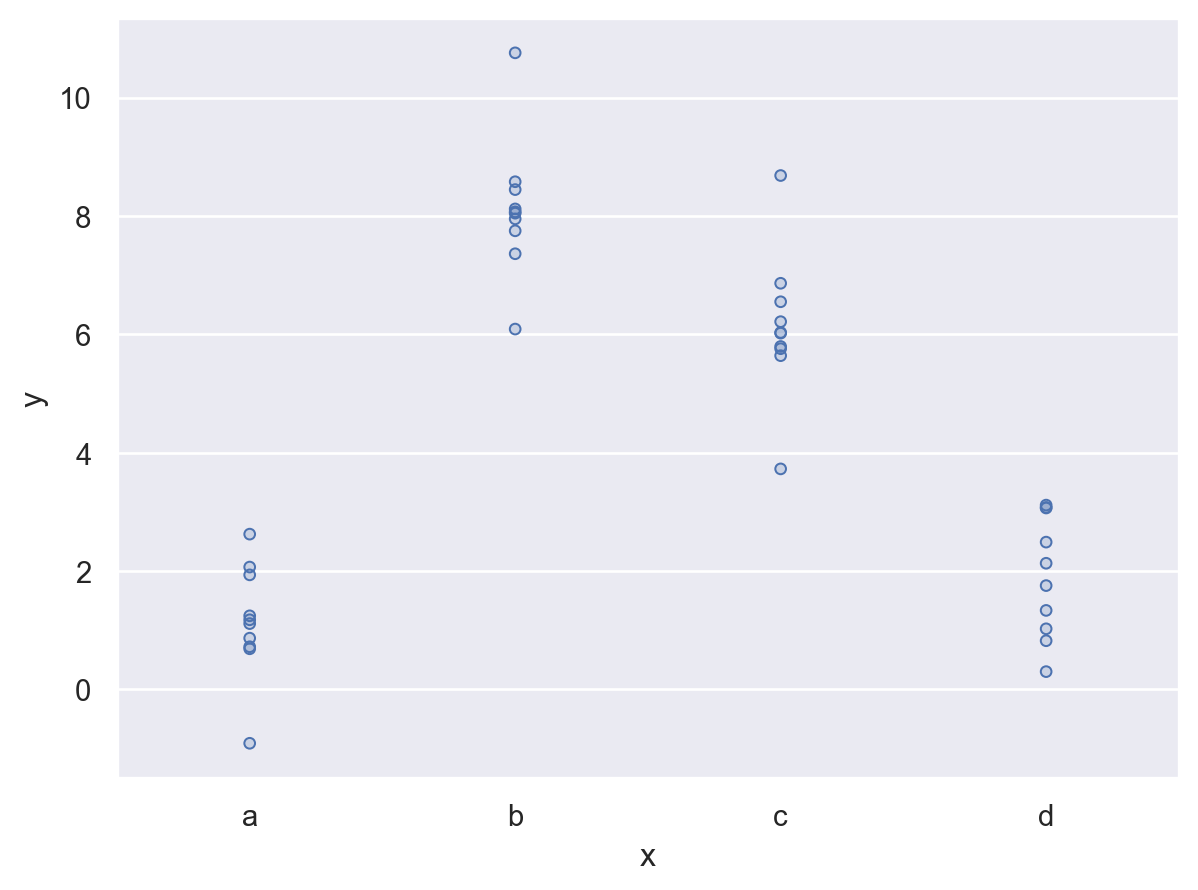

In [92]:
(
    so.Plot(sim2, x='x', y='y')
    .add(so.Dots())
)